In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from tqdm import tqdm
import wandb
import os
import gym
from train_ppo import train_ppo
from models.ppo import PPO
from env.wei_obs_grid import WeightedObsGrid
from utils.utils import uniform_weight, normal_weight, NormalWeightGrid
import pickle
from baseline.dijkstra import dijkstra_grid_with_weights, reconstruct_path
import copy
def create_new_env(grid_size, start, goal, obstacles, weights):
    return WeightedObsGrid(
        grid_size=grid_size,
        start=start,
        goal=goal,
        obstacles=obstacles,
        weights=weights, 
        wei_reset=NormalWeightGrid(grid_size)
    )

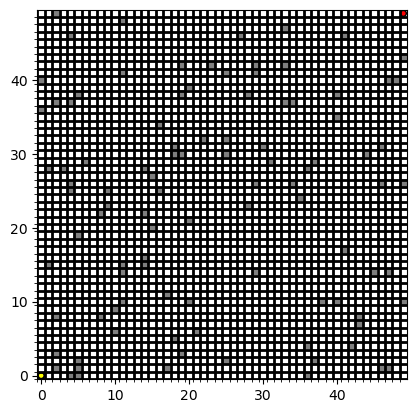

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [53]:
grid_size = (50, 50)
start = (0, 0)
goal = (49, 49)
obstacles = random.sample([(i, j) for i in range(50) for j in range(50) if (i, j) != start and (i, j) != goal], 100)
weights = np.random.rand(grid_size[0], grid_size[1])
env = pickle.load(open('env.pkl', 'rb'))
env.render()
print(env.state['obstacles'])


In [81]:
#grid_wei = copy.deepcopy(env.wei_reset.get_mean_std()[0])
grid_wei = copy.deepcopy(env.state['weight'])
for i in env.obstacles:
    grid_wei[i] = float('inf')
start = env.goal
end = env.start

In [85]:
dis, pred = dijkstra_grid_with_weights(grid_wei,start,end)

print(dis[end[0]][end[1]])
path = reconstruct_path(pred, end)
path.reverse()

40.07836061063496


In [86]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 5000
hidden_dim = 3
gamma = 0.9
epsilon = 0.2
lmbda = 0.9
epochs = 10
reset_interval = 5000
max_steps = 500
state_dim = (4, env.grid_size[0], env.grid_size[1])
action_dim = 4
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, epsilon, lmbda, epochs, device='cuda:0')
agent.load_state_dict(torch.load('saved_model/ppo_50*50.pth'))

<All keys matched successfully>

In [91]:
dijk_cost_list = []
ppo_cost_list = []
for _ in range(100):
    done = False
    iter_num = 0
    ppo_cost = 0
    dijk_cost = 0
    state = env.reset()
    dijk_idx = 0
    while not done:
        iter_num += 1
        eligibles = env.eligible_action_idxes()
        if len(eligibles) == 0:
            break
        action = agent.take_action(state, eligibles)
        next_state, reward, done, _ = env.step(action)
        state = next_state

        ppo_cost += env.state['weight'][int(env.state['current_position'][0])][int(env.state['current_position'][1])]
        if dijk_idx < len(path):
            dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
            dijk_idx += 1
    while dijk_idx < len(path):
        dijk_cost += env.state['weight'][path[dijk_idx][0]][path[dijk_idx][1]]
        dijk_idx += 1
    dijk_cost_list.append(dijk_cost)
    ppo_cost_list.append(ppo_cost)


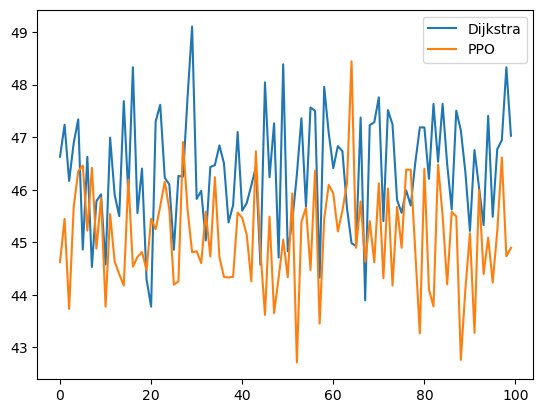

In [92]:
plt.plot(dijk_cost_list, label='Dijkstra')
plt.plot(ppo_cost_list, label='PPO')
plt.legend()

In [102]:
import pandas as pd
df = pd.DataFrame({'Dijkstra': dijk_cost_list, 'PPO': ppo_cost_list})

In [105]:
df.describe().to_markdown()

'|       |   Dijkstra |        PPO |\n|:------|-----------:|-----------:|\n| count |  100       | 100        |\n| mean  |   46.3622  |  45.102    |\n| std   |    1.07735 |   0.972102 |\n| min   |   43.7756  |  42.7126   |\n| 25%   |   45.6488  |  44.3807   |\n| 50%   |   46.4067  |  45.1132   |\n| 75%   |   47.2309  |  45.6761   |\n| max   |   49.1059  |  48.443    |'